In [1]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optax
import numpy as np
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Visualizing the data 

let's start our problem by visualizing the data we will be working with. 

<Figure size 640x480 with 0 Axes>

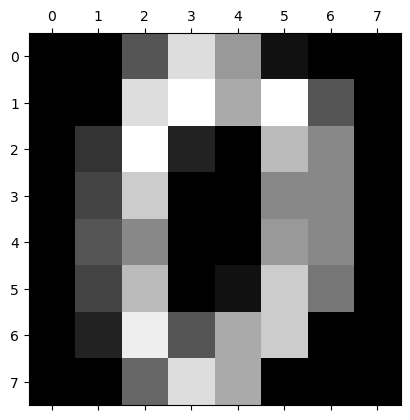

In [2]:
# Load data
digits = load_digits()
Images = digits.data
target = digits.target
#visualize
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [3]:
#Let's rename the input and output variables
x = Images
y = target

Let us transform the target values from an integer representation to a
one-hot-encoder representation. In the following, complete the code.

In [4]:
def one_hot_encoder(x):
    """
    One-Hot Encoder
    
    Converts an array of categorical labels to one-hot encoded representation.
    
    Args:
        x (ndarray): Array of categorical labels.
        
    Returns:
        ndarray: One-hot encoded representation of the input labels.
    """
    # get the number of classes from the input array 
    nclasses = 10 
    # Initialize an array of zeros with shape (number of samples, number of classes)
    out = np.zeros((len(x), nclasses))   
    # Set the corresponding class index to 1 in each sample 
    for i, x_ in enumerate(x):
         out[i, x_] = 1 
        
    return out

# test the function 
target_oh = one_hot_encoder(target)
# test
print(f"target value: {target[40]}, corresponding one-hot vector: {target_oh[40,:]}")

target value: 8, corresponding one-hot vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


# Write the categorical cross entropy loss function 

the loss function for one single datapoint $(x,y)$ is given by:

$$
l = \sum_{n=0}^{N_c} y_{\text{true}}^i \log (y_\text{pred}^i),   
$$
where $N_c$ denotes the number of classes, i.e., 10 in our example.
$y_\text{true}$ and $y_\text{pred}$ denote the true and predicted labels in a
one-hot-encoded representation,
respectively. Finally, $y_{\text{true}}^i$ denotes the $i-th$ component of
$y_{\text{true}}$. 

In the following, complete the code.


In [5]:
@jax.jit
def cat_cross_entropy(params, x, y_true):
    """
    Categorical Cross Entropy Loss Function

    This function calculates the categorical cross entropy loss between the predicted
    probabilities and the true one-hot encoded labels.

    Parameters:
        params (jax.interpreters.xla.DeviceArray): Model parameters.
        x (jax.interpreters.xla.DeviceArray): Input data.
        y_true (jax.interpreters.xla.DeviceArray): True one-hot encoded labels.

    Returns:
        jax.interpreters.xla.DeviceArray: Mean categorical cross entropy loss.
    """
    # Forward pass to obtain predicted probabilities
    y_pred = model.apply(params, x)

    # Calculation of the loss per example
    loss_per_example = -jnp.sum(y_true * jnp.log(y_pred + 1e-8), axis=1)

    # Return the mean loss across all examples
    return jnp.mean(loss_per_example)

In [6]:
class MLP(nn.Module):
    """
    Multi-layer Perceptron
    
    This class represents a Multi-layer Perceptron (MLP) model, which is a type of feedforward neural network.
    MLPs consist of multiple layers of interconnected nodes (called neurons) and are commonly used for
    classification tasks.
    
    Parameters:
        nhidden_units (int): Number of hidden units in each layer.
        nlayers (int, optional): Number of layers in the MLP. Defaults to 1.
        nclasses (int, optional): Number of output classes (categories). Defaults to 10.
    
    Attributes:
        layers (list): List of Dense layers representing the hidden layers in the MLP.
        final_layer (Dense): Final Dense layer for producing the output of the MLP.
    """
    #nhidden_units: 128
    #nlayers = 1
    #nclasses = 10
    

    nhidden_units: int = 128  #隐藏层的感知器数量,使用 dataclass 风格定义，将隐藏层神经元数量设置为 256
    nlayers: int = 1          #隐藏层的层数
    nclasses: int = 10        #输出层的分类数量（不管有多少输入，都输出为10个之1）


    def setup(self):
        """
        Setup the MLP model by creating the hidden layers and the final output layer.
        """
        self.hidden_size = self.nhidden_units
        # create the weight matrices for the hidden layers
        
        self.w0 = self.param('w0', jax.nn.initializers.glorot_uniform(), (64, self.hidden_size))
        self.b0 = self.param('b0', jax.nn.initializers.zeros, (self.hidden_size,))
        self.w1 = self.param('w1', jax.nn.initializers.glorot_uniform(), (self.hidden_size, self.nclasses))
        self.b1 = self.param('b1', jax.nn.initializers.zeros, (self.nclasses,))
    
# @nn.compact: 这个装饰器表示 __call__() 方法中的层需要进行编译，它标记在前向传播时创建的权重和层。
# def __call__(self, x): 定义前向传播的方法，它接受输入 x 并计算网络的输出。    
    @nn.compact
    def __call__(self, x):
        """
        Perform a forward pass through the MLP.
        
        Args:
            x (jax.interpreters.xla.DeviceArray): Input data.
            
        Returns:
            jax.interpreters.xla.DeviceArray: Output of the MLP.
        """

#计算输入 x 与权重矩阵 w0 的点积，再加上偏置项 b0。
#然后使用 ReLU 激活函数，将所有负值置为 0，使模型具有非线性
#将经过 ReLU 激活的结果再与权重矩阵 w1 相乘，加上偏置项 b1，得到输出层的结果

        x = jax.nn.relu(jnp.dot(x, self.w0) + self.b0)
        x = jax.nn.softmax(jnp.dot(x, self.w1) + self.b1)
        

#return x: 返回模型的输出，通常是各类别的分数（称为“logits”）

        return x
    
# initializing the optimizer
#learning_rate = 1e-3: 定义学习率为 0.001，用于优化器
#optx = optax.adam(learning_rate=learning_rate):
#使用 Optax 库中的 Adam 优化器，Adam 是一种自适应的优化方法。
#learning_rate 指定了参数更新的步长，用于引导模型朝着损失最小化的方向调整

learning_rate = 1e-3
optx = optax.adam(learning_rate=learning_rate)

Epoch: 0, Loss: 9.2663, Correct Predictions: 59
Epoch: 10, Loss: 1.5766, Correct Predictions: 329
Epoch: 20, Loss: 0.4561, Correct Predictions: 512
Epoch: 30, Loss: 0.2579, Correct Predictions: 537
Epoch: 40, Loss: 0.1764, Correct Predictions: 558
Epoch: 50, Loss: 0.1267, Correct Predictions: 563
Epoch: 60, Loss: 0.1001, Correct Predictions: 565
Epoch: 70, Loss: 0.0818, Correct Predictions: 570
Epoch: 80, Loss: 0.0675, Correct Predictions: 571
Epoch: 90, Loss: 0.0565, Correct Predictions: 571
Epoch: 100, Loss: 0.0477, Correct Predictions: 573
Epoch: 110, Loss: 0.0409, Correct Predictions: 574
Epoch: 120, Loss: 0.0354, Correct Predictions: 575
Epoch: 130, Loss: 0.0309, Correct Predictions: 575
Epoch: 140, Loss: 0.0272, Correct Predictions: 578
Epoch: 150, Loss: 0.0241, Correct Predictions: 578
Epoch: 160, Loss: 0.0215, Correct Predictions: 579
Epoch: 170, Loss: 0.0193, Correct Predictions: 579
Epoch: 180, Loss: 0.0175, Correct Predictions: 579
Epoch: 190, Loss: 0.0159, Correct Predictio

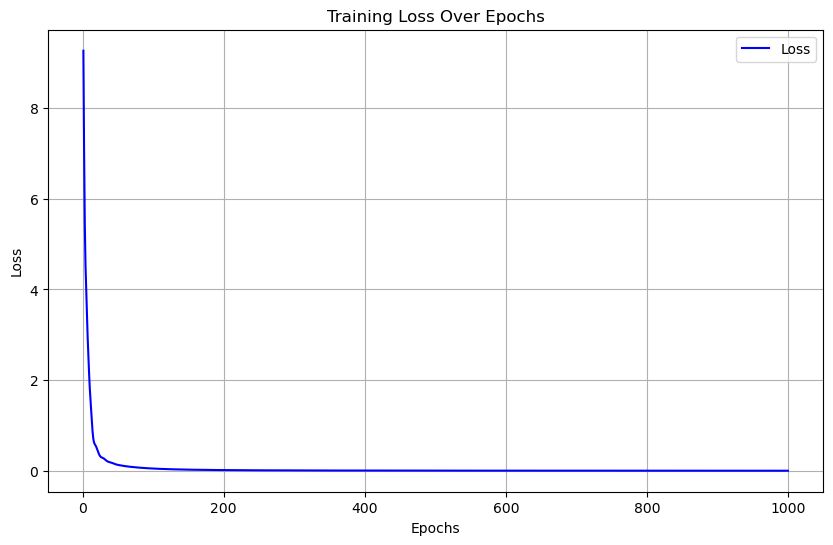

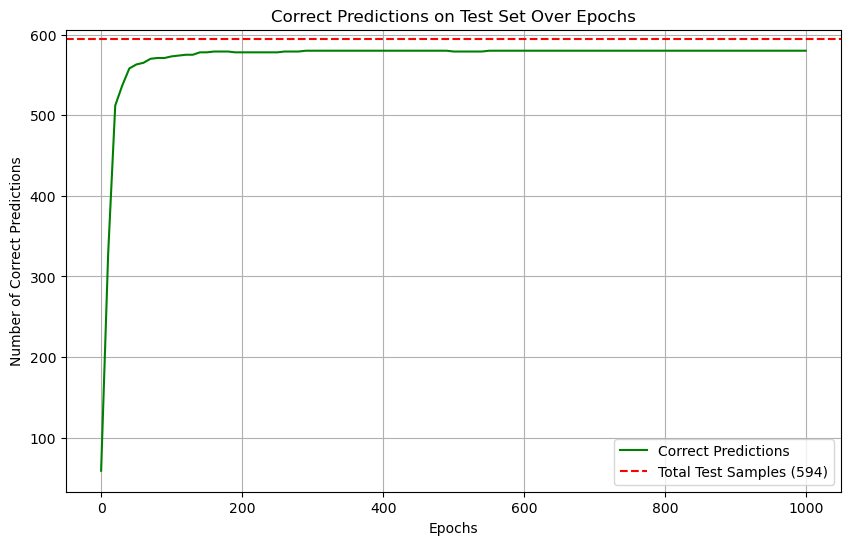

In [7]:
# split the data into training and test data
#train_test_split数据集划分：使用 sklearn 的 train_test_split 函数将数据集划分为训练集和测试集
# test_size=0.33 表示 33% 的数据用于测试，其余用于训练，random_state=42 是随机种子，用于保证结果可复现

x_train, x_test, y_train, y_test = train_test_split(Images, target_oh, test_size=0.33, random_state=42)


# initialize the neural network 
#创建多层感知器模型，隐藏层神经元数量为 256，输出类别为 10
model = MLP(256)    ## 将隐藏层神经元数量改为 256    ## 注意：这里的参数在 Flax 中无法直接传递
params = model.init(jax.random.PRNGKey(0), x_test)  ## 使用训练数据进行初始化

#初始化优化器
#使用 Optax 库的 Adam 优化器初始化参数状态
opt_state = optx.init(params)       

#定义交叉熵损失函数; 计算损失函数及其相对于模型参数的梯度
loss_fn = cat_cross_entropy
loss_grad_fn = jax.value_and_grad(cat_cross_entropy) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 1000 #number of training epochs 
#计算当前参数下的损失和梯度
#根据梯度计算更新值，并更新优化器状态
#将更新值应用于模型参数
#每 100 轮打印一次当前的损失值，便于观察模型的训练过程

# 测试模型
def predict(params, x):
    """
    Make predictions using the trained model.
    
    Args:
        params: Trained model parameters.
        x: Input data.
        
    Returns:
        ndarray: Predicted class indices.
    """
    y_pred = model.apply(params, x)
    return jnp.argmax(y_pred, axis=1)

# 记录 loss 和正确预测数量
loss_history = []
correct_counts = []

# 修改训练循环，记录 loss 和正确预测数量
for e in range(n_epochs):
    # 计算损失和梯度
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    loss_history.append(loss_val)  # 记录当前 epoch 的 loss

    # 每隔 10 个 epoch 测试一次正确预测数量
    if e % 10 == 0 or e == n_epochs - 1:
        y_test_pred = predict(params, x_test)
        correct_predictions = (jnp.argmax(y_test, axis=1) == y_test_pred).sum()
        correct_counts.append(correct_predictions)
        print(f"Epoch: {e}, Loss: {loss_val:.4f}, Correct Predictions: {correct_predictions}")

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# 绘制正确预测数量曲线
plt.figure(figsize=(10, 6))
epochs = list(range(0, n_epochs, 10)) + [n_epochs - 1]  # 对应记录正确预测数量的 epoch
plt.plot(epochs, correct_counts, label="Correct Predictions", color="green")
# 添加测试集总数的红线
test_set_size = x_test.shape[0]  # 测试集总样本数
plt.axhline(y=test_set_size, color='red', linestyle='--', label=f"Total Test Samples ({test_set_size})")
plt.xlabel("Epochs")
plt.ylabel("Number of Correct Predictions")
plt.title("Correct Predictions on Test Set Over Epochs")
plt.legend()
plt.grid()
plt.show()

Model Evaluation Metrics:
Accuracy:  0.9764
Precision: 0.9767
Recall:    0.9764
F1 Score:  0.9764


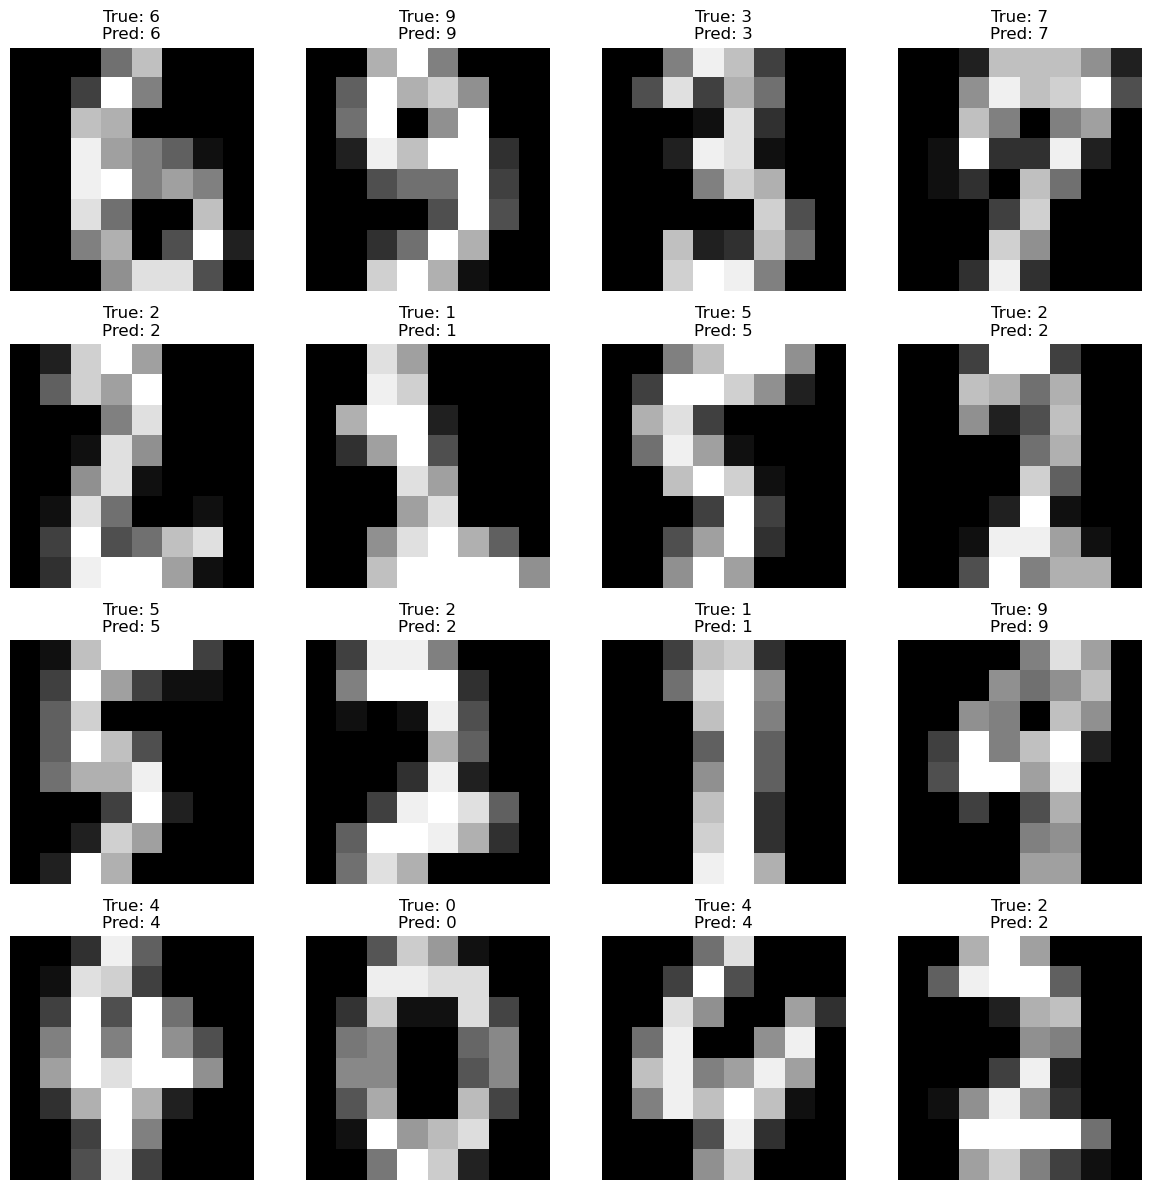

In [8]:
# 使用测试集进行预测
y_test_pred = predict(params, x_test)

# 展示预测结果
def plot_test_images(x_test, y_test_true, y_test_pred, n=16):
    """
    Plot test images with their true and predicted labels.
    
    Args:
        x_test: Test images.
        y_test_true: True labels of test images.
        y_test_pred: Predicted labels of test images.
        n: Number of images to display (default is 16).
    """
    plt.figure(figsize=(12, 12))
    for i in range(min(n, len(x_test))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(x_test[i].reshape(8, 8), cmap='gray')
        plt.axis('off')
        true_label = jnp.argmax(y_test_true[i])
        pred_label = y_test_pred[i]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred):
    """
    Evaluate the model on four metrics: accuracy, precision, recall, and F1 score.
    
    Args:
        y_true: True labels (one-hot encoded).
        y_pred: Predicted class indices.
        
    Returns:
        dict: Dictionary containing the four metrics.
    """
    # 将 one-hot 编码的真实标签转换为类索引
    y_true_labels = jnp.argmax(y_true, axis=1)
    
    # 计算各评估指标
    accuracy = accuracy_score(y_true_labels, y_pred)
    precision = precision_score(y_true_labels, y_pred, average='weighted')
    recall = recall_score(y_true_labels, y_pred, average='weighted')
    f1 = f1_score(y_true_labels, y_pred, average='weighted')
    
    # 打印结果
    print("Model Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # 返回结果字典
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# 调用评估函数
metrics = evaluate_model(y_test, y_test_pred)

# 调用函数，展示前 16 张测试图片的预测结果
plot_test_images(x_test, y_test, y_test_pred, n=16)
